In [1]:
#math and linear algebra stuff
import numpy as np

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# The recursive least square algorithm

## Some notation

By default, we will consider the framework of one dimensional time series, but our purpose can be later extended to multidimensional data.

### Input

Let's begin with the set of input samples:
$$
    \{ u(0), u(1), \dots u(N) \}
$$
Our time serie which will be an input of the RLS algorithm. In the real world, time series are often corrupted with noise, and we are interested in obtaining, for each time point $n$, an estimator $y(n)$ of the original perfect signal $d(n)$

For the convenience of our demonstration, we will consider that all previous signals are available, ie:
$$
    u(k) = 0 \; \forall \; k < 0
$$

We also call
$$
    \{ d(0), d(1), \dots d(N) \}
$$
the desired response, that we wish to recover from $u$

### Output

Let's call
$$
    y(n) = \sum_{k=0}^{M-1} w_k u(n-k)
$$
an estimator of the perfect time serie that can be considered as the result of the application of a linear system or filter over the $M$ previous elements of the time serie.

The $w_k$ are the coefficient of the filter, and we would like to find the one that are the most suited for our estimator.

## The (recursive) least square estimator

The least square estimator is very commonly used in many fields of science and engineering. Part of its success comes from the fact that it can be derived from a simple bayesian reasonning when using a gaussian noise model, in our case it would read:

$$
    \tilde{\vec{y(n)}} = \underset{y}{argmin} \| y(n) - d(n) \|_{2}^{2} \\
    \tilde{\vec{y(n)}} = \langle \vec{w}, \vec{u_n} \rangle
    \text{ When } \vec{w} = \underset{\vec{w}}{argmin} \| \langle \vec{w}, \vec{u_n} \rangle - d(n) \|_{2}^{2}
$$

This approach only takes into account $y(n)$ and $d(n)$ at a single time point to derive the filter $\vec{w}$, and it is probably not the best option in case we have large deviation in a sample.
We can instead, look for a $\vec{w}$ that is optimal for the N last few samples, including the current one, and we can even use a forgetting factor $\beta$ such that the quadratic fidelity take more into account the most recent samples:

$$
    0 < \beta(n,i) \leq 1, i=n-(N-1),n-(N-1)+1,\dots,n
$$

An exponentially decreasy $\beta$ may for instance be a good choice:

$$
   \beta(n,i) = \lambda^{n-i}
$$

We can then define our **_recursive_** least square estimator by using a few linear operators:


With:

$$ R^{n} =
    \begin{pmatrix}
        u(n-(M-1)-(N-1)) & u(n-(M-2)-(N-1)) & \dots & u(n-(N-1))   \\
        u(n-(M-1)-(N-2)) & u(n-(M-2)-(N-2)) & \dots & u(n-(N-2)) \\
        \vdots           & \vdots           & \dots & \vdots   \\
        u(n-(M-1))       & u(n-(M-2))       & \dots & u(n)     \\
    \end{pmatrix}
$$

Describing the content of this matrix is pretty straightforward:
* The row T contains all inputs from $u(T)$ to $u(T-(M-1))$, ie, the $M$ previous entry, that should be used to predict the output $d(T)$
* We have $N$ rows, in order to compute the predictor on the $N$ samples under consideration

If we also want to include the forgetting function $\beta$ in our model then we can use $B$, a nice diagonal matrix of size $N$:
$$ B =
    \begin{pmatrix}
        \beta(0,N-1) & 0 & \dots & 0 \\
        0 & \beta(0,N-2) & \dots & 0 \\
        \vdots           & \vdots  & \ddots & \vdots   \\
        0 & 0 & \vdots & \beta(0,0) \\
    \end{pmatrix}
$$

So at each time step index $n$, we would like to solve:
$$
\begin{align*}
    \hat{\vec{w_n}} = &\underset{\vec{w}}{argmin} \| B^{\frac{1}{2}}(R^{n} \vec{w} - \vec{d_n}) \|_{2}^{2} \\
    \iff &\underset{\vec{w_n}}{argmin} \| (B^{\frac{1}{2}}R^{n} \vec{w_n} - B^{\frac{1}{2}}\vec{d_n}) \|_{2}^{2} \\
\end{align*}
$$
Where $\vec{w_n}$ is the current estimate for $\vec{w}$ at step n
$$\vec{w} = \begin{pmatrix}w_{N-1} \\ w_{N-2} \\ \vdots \\ w_{0}\end{pmatrix}$$
$$\vec{d_n} = \begin{pmatrix}d_{n-(N-1)} \\ d_{n-(N-2)} \\ \vdots \\ d_{n}\end{pmatrix}$$

This is a simple linear least square that can be solved potentially with Moore Penrose Pseudo inverse.
We recall that its expression for the functional : $\frac{1}{2}||Ax-b||_2^2$ is $(A^t A)^{-1}A^t b$, where we can easily identfy
* $A = B^{\frac{1}{2}}R^{n}$
* $b = B^{\frac{1}{2}}\vec{d_n}$
* $x = \vec{w_n}$

Hence providing in this case the following pseudo inverse:
$$
\begin{align*}
    \hat{\vec{w_n}} &= ((B^{\frac{1}{2}}R^{n})^t B^{\frac{1}{2}}R^{n})^{-1} (B^{\frac{1}{2}}R^{n})^t B^{\frac{1}{2}}\vec{d_n} \\
    &= ((R^{n})^t B R^{n})^{-1} (R^{n})^t B\vec{d_n} \\
    &= A_n^{-1} b_n
\end{align*}
$$
With
* $A_n = 2(R^{n})^t B R^{n}$
* $b_n = 2(R^{n})^t B \vec{d_n}$

The factor 2 can be easily simplified

## When the recursivity kicks in

We are now going to take a look at the links between $w_n = A_n^{-1} b_n$ and $w_{n+1} = A_{n+1}^{-1} b_{n+1}$

$$ R^{n} =
    \begin{pmatrix}
        u(n-(M-1)-(N-1)) & u(n-(M-2)-(N-1)) & \dots & u(n-(N-1))   \\
        u(n-(M-1)-(N-2)) & u(n-(M-2)-(N-2)) & \dots & u(n-(N-2)) \\
        \vdots           & \vdots           & \dots & \vdots   \\
        u(n-(M-1))       & u(n-(M-2))       & \dots & u(n)     \\
    \end{pmatrix}
$$

$$ R^{n+1} =
    \begin{pmatrix}
        u(n-(M-1)-(N-1)) & u(n-(M-2)-(N-1)) & \dots & u(n-(N-1)) \\
        u(n-(M-1)-(N-2)) & u(n-(M-2)-(N-2)) & \dots & u(n-(N-2)) \\
        \vdots           & \vdots           & \dots & \vdots     \\
        u(n-(M-1))       & u(n-(M-2))       & \dots & u(n)       \\
        u(n+1-(M-1))       & u(n+1-(M-2))       & \dots & u(n+1) \\
    \end{pmatrix}
$$

Matrix $R^{n+1}$ is like $R^{n}$ with an additional row vector at the bottom

Eventually, it is easier to look at what happens when written in the scalar form:
\begin{align*}
    \hat{\vec{w_n}} = &\underset{\vec{w}}{argmin} \quad \| B^{\frac{1}{2}}(R^{n} \vec{w} - \vec{d_n}) \|_{2}^{2} \\
    \iff &\underset{\vec{w}}{argmin} \quad (R^{n} \vec{w} - \vec{d_n})^t B^{\frac{t}{2}} B^{\frac{1}{2}} (R^{n} \vec{w} - \vec{d_n}) \\
    \iff &\underset{\vec{w}}{argmin} \quad (R^{n} \vec{w} - \vec{d_n})^t B (R^{n} \vec{w} - \vec{d_n}) \\
    \iff &\underset{\vec{w}}{argmin} \quad \sum_{i=0}^{n} B_{i,i} \left(\left(\sum_{k=0}^{M-1} w_k u_{i-k} \right) -d_i\right)^2\\
    \iff &\underset{\vec{w}}{argmin} \quad \sum_{i=0}^{n} \lambda^{n-i} \left(\left(\sum_{k=0}^{M-1} w_k u_{i-k} \right) - d_i\right)^2\\
\end{align*}

We can now use the same form to express what happens at next iteration when a new output $d_{n+1}$ comes in, an get back to the matrix form:
\begin{align*}
    \hat{\vec{w_{n+1}}} = &\underset{\vec{w}}{argmin} \quad \sum_{i=0}^{n+1} \lambda^{n+1-i} \left(\left(\sum_{k=0}^{M-1} w_k u_{i-k} \right) - d_i\right)^2\\
    \iff &\underset{\vec{w}}{argmin} \quad \lambda \sum_{i=0}^{n} \lambda^{n-i} \left(\left(\sum_{k=0}^{M-1} w_k u_{i-k} \right) - d_i\right)^2 + \lambda^0 \left(\left(\sum_{k=0}^{M-1} w_k u_{n+1-k} \right) - d_{n+1}\right)^2\\
    \iff &\underset{\vec{w}}{argmin} \quad \lambda \| B^{\frac{1}{2}}(R^{n} \vec{w} - \vec{d_n}) \|_{2}^{2} + \| \lambda^{\frac{0}{2}} (\vec{u_{n+1-(M-1):n+1}} \cdot \vec{w} - d_{n+1}) \|_{2}^{2} 
\end{align*}

Lets develop this weird expression to its full extent, we decided to replace $u_{n+1-(M-1):n+1}$ with $u(n+1)$ for a better readability
\begin{align*}
    f(\vec{w}) &= \lambda \| B^{\frac{1}{2}}(R^{n} \vec{w} - \vec{d_n}) \|_{2}^{2} + \| \lambda^{\frac{0}{2}} (\vec{u(n+1)} \cdot \vec{w} - d_{n+1}) \|_{2}^{2} \\
    f(w) &= \lambda (B^{\frac{1}{2}}R^{n} w)^T (B^{\frac{1}{2}}R^{n} w) + \lambda(B^{\frac{1}{2}}d_n)^T(B^{\frac{1}{2}}d_n) -2\lambda (B^{\frac{1}{2}}d_n)^T (B^{\frac{1}{2}}R^{n} w) + (u(n+1)^T w)^T(u(n+1)^T w) + d_{n+1}^2 -2 d_{n+1} u(n+1)^T w \\
    &= \lambda w^T (R^{n})^t B R^{n} w + \lambda d_n^T B d_n -2\lambda d_n^T B R^{n} w + w^T u(n+1) u(n+1)^T w + d_{n+1}^2 -2 d_{n+1} u(n+1)^T w
\end{align*}

We recognize a quadratic problem, that we can differentiate with respect to each element of $\vec{w}$:
\begin{align*}
    \frac{\partial f}{\partial w} &= 2\lambda (R^{n})^t B R^{n} w + -2\lambda d_n^T B R^{n} + 2 u(n+1) u(n+1)^T w - 2 d_{n+1} u(n+1)^T \\
    &= 2 \left( \lambda (R^{n})^t B R^{n} + u(n+1) u(n+1)^T \right) w + (-2 \lambda d_n^T B R^{n} - 2 d_{n+1} u(n+1)^T)
\end{align*}

Proving the convexity of the problem happens to be pretty easy, as the Hessian of the problem $\left( \lambda (R^{n})^t B R^{n} + u(n+1) u(n+1)^T \right)$ is symmetric, hence at least positive semi definite.

Even more importantly, we can prove that the solution of the problem at step n can be expressed as a function of solution of the problem at step n+1:

\begin{align*}
    \frac{\partial f}{\partial w} &= 0 \\
    2 \left( \lambda (R^{n})^t B R^{n} + u_{n+1-(M-1):n+1} u_{n+1-(M-1):n+1}^T \right) w -2 \lambda d_n^T B R^{n} - 2 d_{n+1} u_{n+1-(M-1):n+1}^T &= 0 \\
    2 \left( \lambda A_n + u_{n+1-(M-1):n+1} u_{n+1-(M-1):n+1}^T \right) w + -2 \lambda b_n - 2 d_{n+1} u_{n+1-(M-1):n+1}^T &= 0\\
    2 \left( \lambda A_n + C_{n+1} \right) w + -2 \lambda b_n - 2 e_{n+1} &= 0 \quad \text{with } \quad C_{n+1}=u_{n+1-(M-1):n+1} u_{n+1-(M-1):n+1}^T \quad \text{and} \quad e_{n+1} = d_{n+1} u_{n+1-(M-1):n+1}^T\\
    w &= \left( \lambda A_n + C_{n+1} \right)^{-1} \left( \lambda b_n + e_{n+1} \right)
\end{align*}

We recall that we already have a solution for
\begin{align*}
    A_n w - b_n = 0
\end{align*}

In order to generate the coefficient vector we are interested in the inverse of matrix $A_{n+1} = \left( \lambda A_n + C_{n+1} \right)$. For that task the [Woodbury matrix identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) comes in handy.


### The Woodbury matrix identity
Lets assume that $A$, $U$, $C$ and $V$ all denote matrices of the correct (conformable) sizes. Specifically, $A$ is n-by-n, $U$ is n-by-k, $C$ is k-by-k and $V$ is k-by-n. This can be derived using blockwise matrix inversion. 

\begin{align*}
    \left(A+UCV\right)^{-1} &= A^{-1}-A^{-1}U\left(C^{-1}+VA^{-1}U\right)^{-1}VA^{-1}\\
\end{align*}

Lets recall what equality we ended-up with the following matrix to invert:
\begin{align*}
    &\lambda A_n + u_{n+1-(M-1):n+1} u_{n+1-(M-1):n+1}^T \\
    &= \lambda A_n + u(n+1) u(n+1)^T
\end{align*}

We can identify, from the Woodbury matrix identity:
* $A=\lambda A_n$ is an $M\times M$ matrix
* $U=u(n+1)$ is an $M \times 1$ column vector
* $V=u(n+1)^T$ is an $1 \times M$ row vector
* $C=1$ is a scalar

Then write:
\begin{align*}
    A_{n+1}^{-1} &= \left(\lambda A_n + u(n+1) u(n+1)^T\right)^{-1} \\
    &= \lambda^{-1}A_n^{-1}-\lambda^{-1}A_n^{-1}u(n+1)\left(1+\lambda^{-1}u(n+1)^TA_n^{-1}u(n+1)\right)^{-1}u(n+1)^T\lambda^{-1}A_n^{-1}\\
    &= \lambda^{-1}A_n^{-1} - \frac{\lambda^{-1}A_n^{-1}u(n+1)u(n+1)^TA_n^{-1}}{\lambda+u(n+1)^TA_n^{-1}u(n+1)}
\end{align*}

Amazing! we now have an expression for $A_{n+1}^{-1}$ and we know that $b_{n+1}=\lambda b_n + d_{n+1} u_{n+1-(M-1):n+1}^T$.

We can then solve the problem iteratively. 

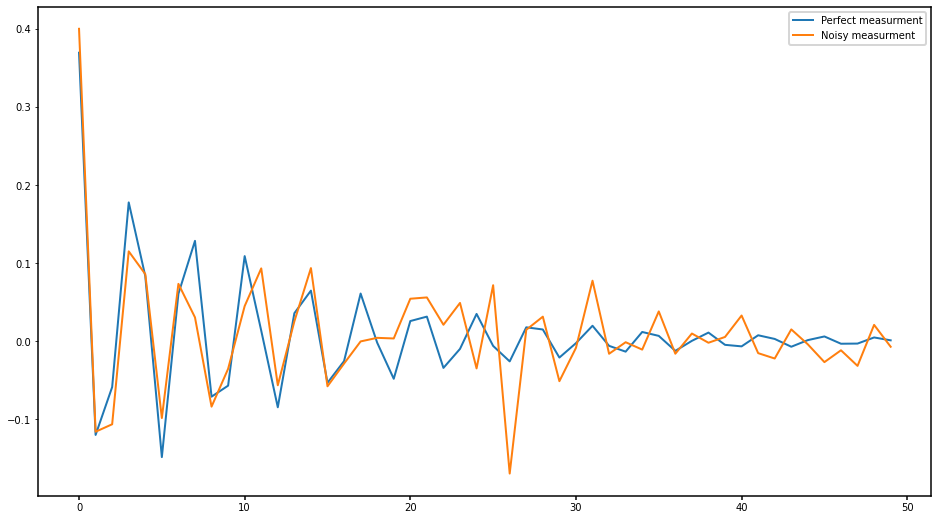

In [5]:
# Numerical application is cool
def gen_autoregressive_ts(order=5, noise_std=0.5):
    init = np.random.rand()
    init_noisy = init + np.random.normal(loc=0,scale=noise_std)
    params = np.random.rand(order)
    params = params-params.mean()+0.05
    features = np.concatenate((np.zeros(max(0,order-1)),[init]))
    features_noisy = np.concatenate((np.zeros(max(0,order-1)),[init_noisy]))
    
    # Now yield
    yield params, np.zeros(order), np.zeros(order), init, init_noisy
    while True:
        new_val = np.dot(features, params)
        new_val_noisy = new_val+np.random.normal(loc=0,scale=noise_std)
        yield params, features, features_noisy, new_val, new_val_noisy
        features = np.roll(features, -1)
        features[-1] = new_val
        features_noisy = np.roll(features_noisy, -1)
        features_noisy[-1] = new_val_noisy

fig, ax = plt.subplots(figsize=(16,9))
ats = gen_autoregressive_ts(order=4, noise_std=0.04)
y = []
y_noisy = []
for i in range(50):
    _,_,_,v,v_n = next(ats)
    y.append(v)
    y_noisy.append(v_n)
ax.plot(y, label="Perfect measurment")
ax.plot(y_noisy, label="Noisy measurment")
ax.legend()

Recursive and non recursive solution just overlaps perfectly, that's amazing :)


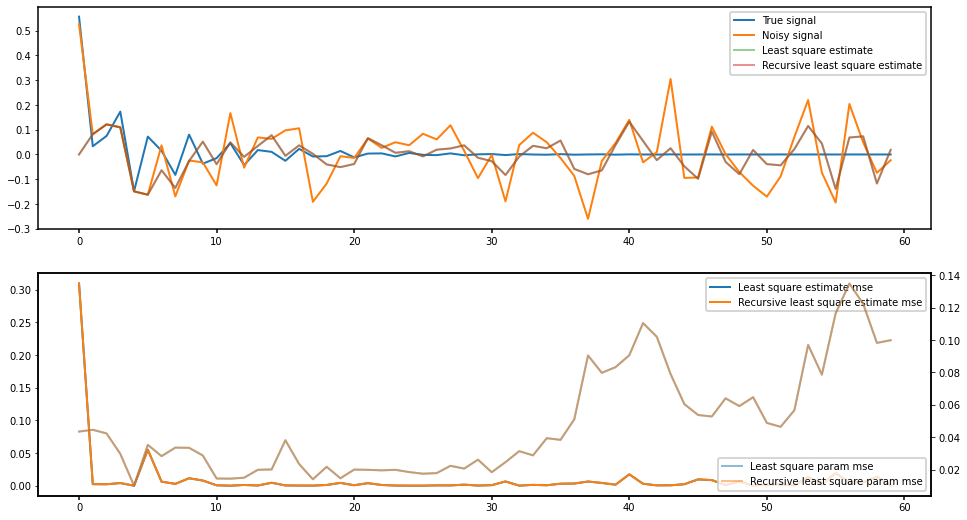

In [8]:
order = 5
lam = 0.90
noise_std = 0.1
ats = gen_autoregressive_ts(order=order, noise_std=noise_std)

ls_param_estimate = []
ls_param_error = []
ls_estimate = []
ls_estimate_error = []

rls_param_estimate = []
rls_param_error = []
rls_estimate = []
rls_estimate_error = []

Rns = []
dns = []
true_val = []

for i in range(60):
    #print(f"========={i}=========")
    params, features, features_noisy, new_val, new_val_noisy = next(ats)
    #print(params, features, features_noisy, new_val, new_val_noisy)
    Rns.append(features_noisy)
    dns.append(new_val_noisy)
    true_val.append(new_val)
    beta = lam**(np.arange(i+1))[::-1]
    
    if i<=0:
        ls_param_estimate.append(np.zeros(order))
        ls_estimate.append(0)
        ls_estimate_error.append(np.square(0-new_val).mean())
        ls_param_error.append(np.square(np.zeros(order)-params).mean())
        rls_param_estimate.append(np.zeros(order))
        rls_estimate.append(0)
        rls_estimate_error.append(np.square(0-new_val).mean())
        rls_param_error.append(np.square(np.zeros(order)-params).mean())
        continue
    valid = -min(i,order)
        
    # LS part
    Rn = np.array(Rns)
    #print("Rn", Rn)
    dn = np.array(dns)
    B = np.diag(beta)
    #print("B", B)
    An = np.dot(Rn.T, np.dot(B, Rn))[valid:,valid:]
    #print("An", An)
    bn = np.dot(Rn.T, np.dot(B, dn))[valid:]
    #print("bn", bn)
    ls_param_estimate.append(np.concatenate((np.zeros(max(order-i,0)),np.dot(np.linalg.inv(An),bn))))
    ls_estimate.append(np.dot(features_noisy, ls_param_estimate[-1]))
    ls_estimate_error.append(np.square(ls_estimate[-1]-new_val).mean())
    ls_param_error.append(np.square(ls_param_estimate[-1]-params).mean())
    
    # RLS part
    un1 = features_noisy
    if i<=order:
        Anm1 = np.linalg.inv(An)
        bn1 = bn
    else:
        Anm1 = (1/lam)*Anm1-((1/lam)*np.dot(Anm1, np.dot(np.outer(un1,un1),Anm1)))/(lam+np.dot(un1, np.dot(Anm1,un1)))
        en = new_val_noisy*un1
        bn1 = lam*bn1+en
    rls_param_estimate.append(np.concatenate((np.zeros(max(order-i,0)),np.dot(Anm1,bn1))))
    rls_estimate.append(np.dot(features_noisy, rls_param_estimate[-1]))
    rls_estimate_error.append(np.square(rls_estimate[-1]-new_val).mean())
    rls_param_error.append(np.square(rls_param_estimate[-1]-params).mean())

    
fig, ax = plt.subplots(2,1,figsize=(16,9))
ax[0].plot(true_val, label="True signal")
ax[0].plot(dns, label="Noisy signal")
ax[0].plot(ls_estimate, label="Least square estimate",alpha=0.5)
ax[0].plot(rls_estimate, label="Recursive least square estimate", alpha=0.5)
ax[0].legend()

ax[1].plot(ls_estimate_error, label="Least square estimate mse")
ax[1].plot(rls_estimate_error, label="Recursive least square estimate mse")
ax[1].legend()
ax1_twin = ax[1].twinx()
ax1_twin.plot(ls_param_error, label="Least square param mse", alpha=0.5)
ax1_twin.plot(rls_param_error, label="Recursive least square param mse", alpha=0.5)
ax1_twin.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.85))

print("Recursive and non recursive solution just overlaps perfectly, that's amazing :)")

## Lattice recursive least square
According to [wikipedia](https://en.wikipedia.org/wiki/Recursive_least_squares_filter) there is something called lattice recursive least square that is much better.
TODO

## Kalmann filter
As usual, [wikipedia](https://en.wikipedia.org/wiki/Kalman_filter) gives a pretty good overview of what kalmann filtering is.
Basically, it is a beefier version of recursive least square that also embeds a noise covariance estimation procedure.

We find it particularly interesting as a tool, because this method is compatible with multidimensional time series, hence can be used for multi-sensor fusion.

### Definition
From wikipedia: The Kalman filter produces an estimate of the state of the system as an average of the system's predicted state and of the new measurement using a weighted average. The purpose of the weights is that values with better (i.e., smaller) estimated uncertainty are "trusted" more. The weights are calculated from the covariance, a measure of the estimated uncertainty of the prediction of the system's state.

More formally, the Kalman filter is an efficient recursive filter that estimates the internal state of a linear dynamic system from a series of noisy measurements. It is used in a wide range of engineering and econometric applications from radar and computer vision to estimation of structural macroeconomic models, and is an important topic in control theory and control systems engineering. Together with the linear-quadratic regulator (LQR), the Kalman filter solves the linear–quadratic–Gaussian control problem (LQG). The Kalman filter, the linear-quadratic regulator, and the linear–quadratic–Gaussian controller are solutions to what arguably are the most fundamental problems in control theory.

In most applications, the internal state is much larger (more degrees of freedom) than the few "observable" parameters which are measured. However, by combining a series of measurements, the Kalman filter can estimate the entire internal state.

### Kalmann filter gain
The relative certainty of the measurements and current state estimate is an important consideration, and it is common to discuss the response of the filter in terms of the Kalman filter's gain. The Kalman gain is the relative weight given to the measurements and current state estimate, and can be "tuned" to achieve a particular performance. With a high gain, the filter places more weight on the most recent measurements, and thus follows them more responsively.

### Covariance estimation
When performing the actual calculations for the filter (as discussed below), the state estimate and covariances are coded into matrices to handle the multiple dimensions involved in a single set of calculations. This allows for a representation of linear relationships between different state variables (such as position, velocity, and acceleration) in any of the transition models or covariances.


## Shall we start now: the actual model
Kalman filters are based on linear dynamical systems discretized in the time domain. They are modeled on a Markov chain built on linear operators perturbed by errors that may include Gaussian noise. The state of the system is represented as a vector of real numbers. At each discrete time increment, a linear operator is applied to the state to generate the new state, with some noise mixed in, and optionally some information from the controls on the system if they are known. Then, another linear operator mixed with more noise generates the observed outputs from the true ("hidden") state. The Kalman filter may be regarded as analogous to the hidden Markov model, with the key difference that the hidden state variables take values in a continuous space (as opposed to a discrete state space as in the hidden Markov model). There is a strong analogy between the equations of the Kalman Filter and those of the hidden Markov model.

In order to use the Kalman filter to estimate the internal state of a process given only a sequence of noisy observations, one must model the process in accordance with the framework of the Kalman filter. This means specifying the following matrices:

* $F_k$ the state transition model
* $H_k$ the observation model
* $Q_k$ the covariance of the process noise
* $R_k$ the covariance of the observation noise
* and sometimes $B_k$, the control-input model, for each time-step, k, as described below.

The Kalman filter model assumes the true state at time k is evolved from the state at (k − 1) according to

\begin{align*}
    x _k = F_k x_{k-1} + B_k u_k + w_k
\end{align*}
where

* $F_k$ is the state transition model which is applied to the previous state $x_{k−1}$
* $B_k$ is the control-input model which is applied to the control vector $u_k$;
* $w_k$ is the process noise which is assumed to be drawn from a zero mean multivariate normal distribution, $\mathcal{N}$, with covariance, $Q_k: \mathbf w_k \sim \mathcal{N} \left(0,Q_k\right)$

At time $k$ an observation (or measurement) $z_k$ of the true state $x_k$ is made according to

\begin{align*}
    z_k = H_k x_k + v_k
\end{align*}

where

* $H_k$ is the observation model which maps the true state space into the observed space and
* $v_k$ is the observation noise which is assumed to be zero mean Gaussian white noise with covariance $R_k: v_k \sim \mathcal{N} \left(0,R_k\right)$

The initial state, and the noise vectors at each step $\{x_0, w_1, \dots, w_k, v_1, \dots, v_k\}$ are all assumed to be mutually independent.

Many real dynamical systems do not exactly fit this model. In fact, unmodeled dynamics can seriously degrade the filter performance, even when it was supposed to work with unknown stochastic signals as inputs. The reason for this is that the effect of unmodeled dynamics depends on the input, and, therefore, can bring the estimation algorithm to instability (it diverges). On the other hand, independent white noise signals will not make the algorithm diverge. The problem of distinguishing between measurement noise and unmodeled dynamics is a difficult one and is treated in control theory under the framework of robust control.

### What needs to be solved/updated in this model
The Kalman filter is a recursive estimator. This means that only the estimated state from the previous time step and the current measurement are needed to compute the estimate for the current state. In contrast to batch estimation techniques, no history of observations and/or estimates is required. In what follows, the notation $\hat{x}_{n\mid m}$ represents the estimate of $\mathbf{x}$  at time $n$ given observations up to and including at time $m \leq n$.

The state of the filter is represented by two variables:

* $\hat{x}_{k\mid k}$, the a posteriori state estimate at time k given observations up to and including at time k
* $P_{k \mid k}$ the a posteriori estimate covariance matrix (a measure of the estimated accuracy of the state estimate).

The Kalman filter can be written as a single equation, however it is most often conceptualized as two distinct phases: "Predict" and "Update". The predict phase uses the state estimate from the previous timestep to produce an estimate of the state at the current timestep. This predicted state estimate is also known as the a priori state estimate because, although it is an estimate of the state at the current timestep, it does not include observation information from the current timestep. In the update phase, the current a priori prediction is combined with current observation information to refine the state estimate. This improved estimate is termed the a posteriori state estimate.

Typically, the two phases alternate, with the prediction advancing the state until the next scheduled observation, and the update incorporating the observation. However, this is not necessary; if an observation is unavailable for some reason, the update may be skipped and multiple prediction steps performed. Likewise, if multiple independent observations are available at the same time, multiple update steps may be performed (typically with different observation matrices $H_k$)

#### Predict
* Predicted (a priori) state estimate $\hat{x}_{k\mid k-1} = F_k \hat{x}_{k-1\mid k-1} + B_k u_k$
* Predicted (a priori) estimate covariance	$P _{k\mid k-1} = F_k P_{k-1 \mid k-1} F_k^T+Q_k$

#### Update
* Innovation or measurement pre-fit residual $\tilde{y}_{k}=z_k-H_k \hat{x}_{k\mid k-1}$
* Innovation (or pre-fit residual) covariance $S_k=H_k P_{k\mid k-1} H_k^T+R_k$
* Optimal Kalman gain $K_k = P_{k\mid k-1} H_k^T S_k^{-1}$
* Updated (a posteriori) state estimate	$\hat{x}_{k\mid k}=\hat{x}_{k\mid k-1}+K_k \tilde{y}_k$
* Updated (a posteriori) estimate covariance $P_{k\mid k} = \left(I -K_k H_k\right) P _{k|k-1}$
* Measurement post-fit residual	$\tilde{y}_{k\mid k}=z_k-H_k \hat{x}_{k\mid k}$

The formula for the updated (a posteriori) estimate covariance above is valid for the optimal $K_k$ gain that minimizes the residual error, in which form it is most widely used in applications. Proof of the formulae is found in the derivations section, where the formula valid for any $K_k$ is also shown.

## Estimation of the noise covariances $Q_k$ and $R_k$
Practical implementation of the Kalman Filter is often difficult due to the difficulty of getting a good estimate of the noise covariance matrices $Q_k$ and $R_k$. Extensive research has been done in this field to estimate these covariances from data. One practical approach to do this is the autocovariance least-squares (ALS) technique that uses the time-lagged autocovariances of routine operating data to estimate the covariances.

Field Kalman Filter (FKF), a Bayesian algorithm, which allows simultaneous estimation of the state, parameters and noise covariance has been proposed in [this document](https://www.researchgate.net/profile/Piotr_Bania/publication/312029167_Field_Kalman_Filter_and_its_approximation/links/5bbf0eda45851572315edfbe/Field-Kalman-Filter-and-its-approximation.pdf). FKF algorithm has a recursive formulation, good observed convergence and relatively low complexity. This gives a possibility that the FKF algorithm may be an alternative to the Autocovariance Least-Squares methods.

# Going further:
F. Cavenago et al. 2019. "On-board spacecraft relative pose estimation with high-order extended Kalman filter." Acta Astronautica, vol. 158, pp. 55-67, http://www.sciencedirect.com/science/article/pii/S0094576518301516